# Install and import libraries

In [1]:
%pip install pydot
%pip install tensorflow
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical, plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from pathlib import Path

from constants import (
    DATA_INPUT_PATH,
    CLASSES,
    MODEL_PATH,
    METADATA_PATH,
)

# Read the files in the data dir

In [27]:
# Read all of the files in the data folder
files_in_folder = Path(DATA_INPUT_PATH).rglob("*.csv")

files = [x for x in files_in_folder]
print([file for file in files])

[WindowsPath('data/7_4.csv')]


## Convert .csv(s) to dataframes and concatenate

In [28]:
# Read the data from the files
dfs = []

for file in files:
    df = pd.read_csv(str(file))
    dfs.append(df)
        
# Convert the data to a DataFrame
df = pd.concat([x for x in dfs], axis=0)

print(df.head())

# Before removing duplicates
print(f"Shape of dataframe before removing duplicates {df.shape}")
# Remove duplicates
df = df.drop_duplicates()
print(f"Shape of dataframe after removing duplicates {df.shape}")

# Print out the columns
# classes = {
#     "0": "unmarked",
#     "1": "rest",
#     "2": "clenched_fist",
#     "3": "wrist_flexion",
#     "4": "wrist_extension",
#     "5": "radial_deviations",
#     "6": "ulnar_deviations",
#     "7": "extended_palm"
# }

   Sensor1  Sensor2  Sensor3  Sensor4  Sensor5  Sensor6  Sensor7  Sensor8  \
0       -1        1       -1       -5       -7       -3       -2       -1   
1        1        1        2        3        1        1        1        0   
2       -1        1       -3       -2       -2        5        2        1   
3       -2        0       -2        0       -5        2        0        1   
4       -2       -2       -3       -4        4       -4       -2       -2   

   Sensor9  Sensor10  Sensor11  Sensor12  Sensor13  Sensor14  Sensor15  \
0       -2        -2        -2         0        12         5        -1   
1       -1        -3         0        -2        -2        -2        -1   
2        1         0        -1        -1        -7       -11        -2   
3        1         0        -1        -1        -2        -1         3   
4       -2        -3        -3        -2        24         4        -1   

   Sensor16  Label  
0        -2      0  
1        -1      0  
2         0      0  
3       

## Visualise the dataset

In [30]:
CLASSES = {
    0: "rest", #saftey
    1: "closed_fist", #go up
    2: "open_palm", #go down
    3: "ok", #go forwards
    4: "pointer_finger", #go backwards
    5: "peace", #roatate left
    6: "shaaa", #rotate right
    7: "peace_among_worlds", #do a flip
}


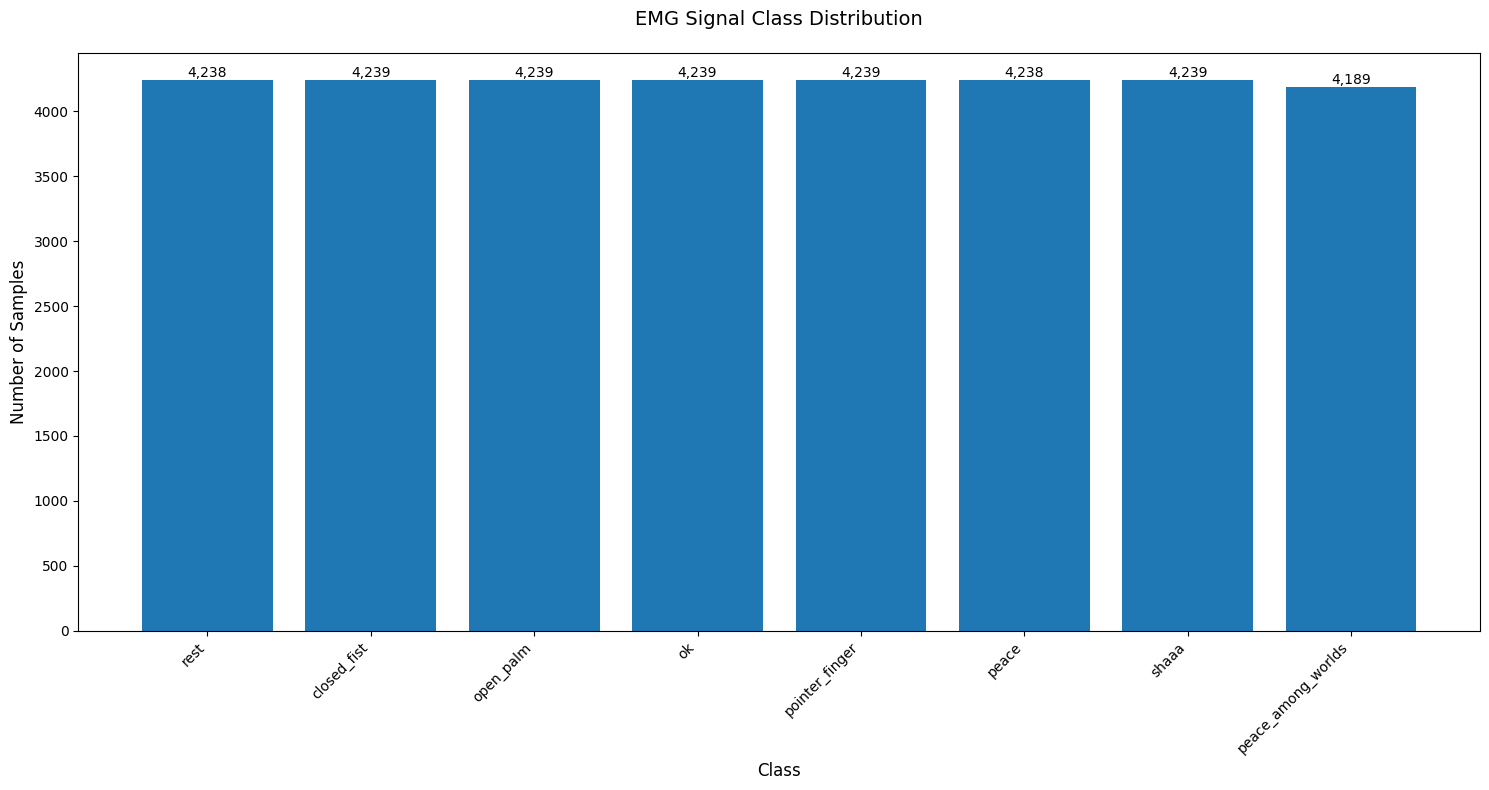

In [31]:
class_counts = df['Label'].value_counts().sort_index()

plt.figure(figsize=(15, 8))
bars = plt.bar(range(len(class_counts)), class_counts.values)

plt.title('EMG Signal Class Distribution', fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

# Set x-axis ticks with class labels
plt.xticks(range(len(class_counts)), [CLASSES[i] for i in range(len(class_counts))], rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Scale and clean the data, then train the model

In [32]:
X = df.drop(columns=['Label'])
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# filter for valid classes because the data is not clean
valid_classes = [0, 1]
mask_train = y_train.isin(valid_classes)
mask_test = y_test.isin(valid_classes)

# apply the mask to the training and testing data
X_train_filtered = X_train_scaled[mask_train]
y_train_filtered = y_train[mask_train]

X_test_filtered = X_test_scaled[mask_test]
y_test_filtered = y_test[mask_test]

# one hot encode the target data
y_train_categorical = to_categorical(y_train_filtered, num_classes=8)
y_test_categorical = to_categorical(y_test_filtered, num_classes=8)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_filtered.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='softmax'))  # Softmax for 8 output classes

# Compile the model with categorical crossentropy for multi-class classification
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the filtered training data
model.fit(X_train_filtered, y_train_categorical, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the model on the filtered test set
test_loss, test_acc = model.evaluate(X_test_filtered, y_test_categorical)

print(f"Test accuracy: {test_acc}")

c:\Users\willi\Desktop\Uni\3rd_year\NLP\CW1\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4079 - loss: 1.7578 - val_accuracy: 0.8027 - val_loss: 1.0345
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7313 - loss: 0.5761 - val_accuracy: 0.8315 - val_loss: 0.6150
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7957 - loss: 0.4750 - val_accuracy: 0.8551 - val_loss: 0.4564
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8092 - loss: 0.4442 - val_accuracy: 0.8596 - val_loss: 0.3959
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8154 - loss: 0.4328 - val_accuracy: 0.8729 - val_loss: 0.3560
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8682 - loss: 0.3534
Test accuracy: 0.8588921427726746


In [36]:
# Save the model
model.save(MODEL_PATH)

# Save the scaler and the column names to a pickle file
with open(METADATA_PATH, 'wb') as f:
    pickle.dump((scaler, X_train.columns), f)